In [1]:
from IPython.display import clear_output
import numpy as np
import matplotlib.pyplot as plt
from random import choice
from matplotlib.image import BboxImage
from matplotlib.transforms import Bbox, TransformedBbox
from skimage.transform import resize
from PIL import Image
from scipy.stats import norm
import glob
import tensorflow as tf
import sys
sys.path.append('..')
from utils import *
#from tensorflow.contrib import layers

### Load Data list names
Rather than load all the data into ram. We just load the names of all the images and annotations. Shuffle the names and partition them into train and test sets. Then we only load the images/annotations when neeed.

In [18]:
base_dir      = '../data/color_120_160_annotated/'
image_dir     = base_dir + 'images/'
anno_dir      = base_dir + 'annotations/'
train_path = '../data/evened_train.txt'
test_path  = '../data/evened_test.txt'

raw_train = load_data(train_path)
raw_test = load_data(test_path)

# Bin Steering Data
The steering and throttle annotations come in as numbers between 0 and 1023. So our network does not need to have 1024 output neurons we partition the data into bins.

ie:

if we had data consisting of numbers 0-9 :



`data = [1,4,5,0,9,8,5,4,3,2,5,6,7]`

and we binned in lost of 2 the our data would look like this:
```
# bins:  0   1   2   3   4
# nums: 01, 23, 45, 67, 89

binned = [0,2,2,0,4,4,2,2,1,1,2,3,3]
```

In [19]:
NUM_BINS = 15
train = bin_steering_annos(raw_train, NUM_BINS)
test = bin_steering_annos(raw_test, NUM_BINS)
for i,a in train[100:110]:
    print(a)

4.0
8.0
12.0
8.0
1.0
10.0
3.0
7.0
5.0
10.0


## Data Generator

This is what we're going to use to take care of loading our actual images and annotations as we need them. When initalized it shuffles the `data_names` then calling the `get_next_bacth` function returns a tuple of `(images, annotations)`. Calling the `still_has_data`function returns a boolean indicating wether or not all the data has been used up.

In [20]:
from data_generator import DataGenerator

In [21]:
my_data=DataGenerator(batch_size=10, 
                      data_set=train,
                      image_dir=image_dir,
                      anno_dir=anno_dir, 
                      num_bins=NUM_BINS)


Below we plot a histogram of the data we're going to use to train the model. Just to make sure there is not a crazy bias in the data.

*eg: if the video containing the data has the car parked for a few seconds at the beginning and end of a run you may get a large spike in the data around 'go strait'*

anno check: min: 0.0, max: 14.0, mean: 6.812962962962963


(array([ 471.,  344., 1458.,  902.,  909., 1483.,  528., 1073.,  323.,
         609.]),
 array([ 0. ,  1.4,  2.8,  4.2,  5.6,  7. ,  8.4,  9.8, 11.2, 12.6, 14. ]),
 <a list of 10 Patch objects>)

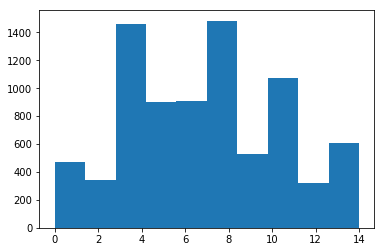

In [22]:
annos = my_data._all_annotations()
print("anno check: min: {}, max: {}, mean: {}".format(np.min(annos), np.max(annos), np.mean(annos)))
plt.hist(annos)

anno check: min: 0.0, max: 12.0, mean: 5.6
(10, 120, 160, 3)
None


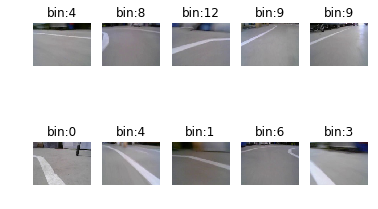

In [26]:
images, annos = my_data.get_next_batch()
print("anno check: min: {}, max: {}, mean: {}".format(np.min(annos), np.max(annos), np.mean(annos)))
print(print(np.shape(images)))
for i, (im, an) in enumerate(zip(images[:10], annos[:10])):
    plot = i+1
    plt.subplot(2,5,plot)
    if np.shape(images)[3] == 1:
        plt.imshow(im[:,:,0])
    else:
        plt.imshow(im[:,:,])
    plt.axis('off')
    angle = an
    plt.title("bin:{}".format(int(angle)))


### Some hyperparams

In [27]:
from show_graph import show_graph
from tf_donkey import Model
car_brain = Model("test_name", in_shape=(120,160,3), num_bins=NUM_BINS)

### Defining the model

In [28]:
train_gen=DataGenerator(batch_size=50, 
                      data_set=train,
                      image_dir=image_dir,
                      anno_dir=anno_dir, 
                      num_bins=NUM_BINS)

test_gen=DataGenerator(batch_size=50, 
                      data_set=test,
                      image_dir=image_dir,
                      anno_dir=anno_dir, 
                      num_bins=NUM_BINS)

In [29]:
epochs = 20
batch_size = 50
learning_rate = 0.001
car_brain.Train(train_gen=train_gen,
               test_gen=test_gen,
               epochs=epochs)



Epoch 1:   0%|          | 0/162 [00:00<?, ?it/s]

Epoch 1
Training


Epoch 2:   0%|          | 0/162 [00:00<?, ?it/s]

Test Loss: 2.472, Test Acc: 0.815
--------------------------------------------------
Model saved at ./ep_1-step_161-loss_2.47.ckpt
Epoch 2
Training


Epoch 3:   0%|          | 0/162 [00:00<?, ?it/s]

Test Loss: 2.324, Test Acc: 0.826
--------------------------------------------------
Model saved at ./ep_2-step_161-loss_2.32.ckpt
Epoch 3
Training


Epoch 4:   0%|          | 0/162 [00:00<?, ?it/s]

Test Loss: 2.177, Test Acc: 0.842
--------------------------------------------------
Model saved at ./ep_3-step_161-loss_2.18.ckpt
Epoch 4
Training


Epoch 5:   0%|          | 0/162 [00:00<?, ?it/s]

Test Loss: 2.019, Test Acc: 0.863
--------------------------------------------------
Model saved at ./ep_4-step_161-loss_2.02.ckpt
Epoch 5
Training


Epoch 6:   0%|          | 0/162 [00:00<?, ?it/s]

Test Loss: 1.888, Test Acc: 0.886
--------------------------------------------------
Model saved at ./ep_5-step_161-loss_1.89.ckpt
Epoch 6
Training


Epoch 7:   0%|          | 0/162 [00:00<?, ?it/s]

Test Loss: 1.905, Test Acc: 0.881
--------------------------------------------------
Epoch 7
Training


Epoch 8:   0%|          | 0/162 [00:00<?, ?it/s]

Test Loss: 1.757, Test Acc: 0.894
--------------------------------------------------
Model saved at ./ep_7-step_161-loss_1.76.ckpt
Epoch 8
Training


Epoch 9:   0%|          | 0/162 [00:00<?, ?it/s]

Test Loss: 1.667, Test Acc: 0.904
--------------------------------------------------
Model saved at ./ep_8-step_161-loss_1.67.ckpt
Epoch 9
Training


Epoch 10:   0%|          | 0/162 [00:00<?, ?it/s]

Test Loss: 1.619, Test Acc: 0.913
--------------------------------------------------
Model saved at ./ep_9-step_161-loss_1.62.ckpt
Epoch 10
Training


Epoch 11:   0%|          | 0/162 [00:00<?, ?it/s]

Test Loss: 1.512, Test Acc: 0.920
--------------------------------------------------
Model saved at ./ep_10-step_161-loss_1.51.ckpt
Epoch 11
Training


Epoch 12:   0%|          | 0/162 [00:00<?, ?it/s]

Test Loss: 1.434, Test Acc: 0.924
--------------------------------------------------
Model saved at ./ep_11-step_161-loss_1.43.ckpt
Epoch 12
Training


Epoch 13:   0%|          | 0/162 [00:00<?, ?it/s]

Test Loss: 1.430, Test Acc: 0.924
--------------------------------------------------
Model saved at ./ep_12-step_161-loss_1.43.ckpt
Epoch 13
Training


Epoch 14:   0%|          | 0/162 [00:00<?, ?it/s]

Test Loss: 1.466, Test Acc: 0.922
--------------------------------------------------
Epoch 14
Training


Epoch 15:   0%|          | 0/162 [00:00<?, ?it/s]

Test Loss: 1.236, Test Acc: 0.939
--------------------------------------------------
Model saved at ./ep_14-step_161-loss_1.24.ckpt
Epoch 15
Training


Epoch 16:   0%|          | 0/162 [00:00<?, ?it/s]

Test Loss: 1.246, Test Acc: 0.937
--------------------------------------------------
Epoch 16
Training


Epoch 17:   0%|          | 0/162 [00:00<?, ?it/s]

Test Loss: 1.222, Test Acc: 0.941
--------------------------------------------------
Model saved at ./ep_16-step_161-loss_1.22.ckpt
Epoch 17
Training


Epoch 18:   0%|          | 0/162 [00:00<?, ?it/s]

Test Loss: 1.159, Test Acc: 0.948
--------------------------------------------------
Model saved at ./ep_17-step_161-loss_1.16.ckpt
Epoch 18
Training


Epoch 19:   0%|          | 0/162 [00:00<?, ?it/s]

Test Loss: 1.052, Test Acc: 0.953
--------------------------------------------------
Model saved at ./ep_18-step_161-loss_1.05.ckpt
Epoch 19
Training


Epoch 20:   0%|          | 0/162 [00:00<?, ?it/s]

Test Loss: 1.150, Test Acc: 0.950
--------------------------------------------------
Epoch 20
Training


Testing: 100%|██████████| 41/41 [00:11<00:00,  3.72it/s]

Test Loss: 1.186, Test Acc: 0.945
--------------------------------------------------
Done, final best loss: 1.05


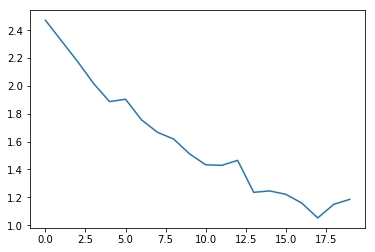

In [31]:
tr_loss, te_loss, te_acc = car_brain.TrainingResults()
plt.plot(te_loss)
fig = plt.gcf()
fig.savefig('tf_donkey_clr_15bins.png', dpi=100)

### Perform Prediction on images using ONLY test data


In [32]:
test_gen = DataGenerator(batch_size=10, 
                      data_set=test[:100],
                      image_dir=image_dir,
                      anno_dir=anno_dir, 
                      num_bins=NUM_BINS)
images, annos = test_gen.get_next_batch()
ckpt = "ep_18-step_161-loss_1.05.ckpt"
probs, preds = car_brain.Predict(images, ckpt)
pred_angles = car_brain.ExpectedBinToDeg(preds)

INFO:tensorflow:Restoring parameters from ep_18-step_161-loss_1.05.ckpt


len:  10


/home/jp/anaconda3/envs/py3_tf16/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Text(0,0.5,'Prob')

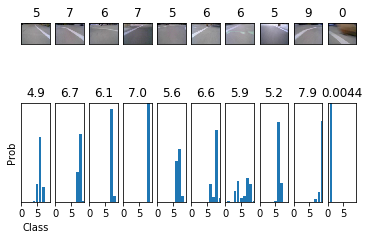

In [34]:
bins = list(range(1,NUM_BINS+1))
y_pos = np.arange(8)
print("len: ", len(annos))
for i, (im, an, prob, pred) in enumerate(zip(images, annos, probs, preds)):
    plot = i + 1
    plt.subplot(2,10,plot)
    plt.xticks([])    
    plt.yticks([])
    plt.title("{}".format(int(an)))
    if np.shape(images)[3] == 1:
        plt.imshow(im[:,:,0])
    else:
        plt.imshow(im[:,:,])
    
    plot += 10
    plt.subplot(2,10,plot)
    plt.bar(bins, prob)
    plt.axis([0, 9, 0, 1.])
    plt.yticks([],[])
    plt.title("{:.2}".format(pred))
    
plt.subplot(2,10,11)
plt.xlabel("Class")
plt.ylabel("Prob")
#plt.yticks([0.,0.2, 0.4, 0.6, 0.8, 1.0])

In [35]:
all_data_sequential = load_data("../data/all_data_sequential.txt")
all_img_paths = [f"../data/color_120_160_annotated/images/{ele[0]}.jpg" for ele in all_data_sequential]
all_data_sequential_binned = bin_steering_annos(all_data_sequential, NUM_BINS)
# all_images    = load_images(all_img_paths)

In [36]:
all_gen = DataGenerator(batch_size=50, 
                      data_set=all_data_sequential_binned,
                      image_dir=image_dir,
                      anno_dir=anno_dir, 
                      num_bins=NUM_BINS,
                      shuffle=False)
annotations = [ele[1] for ele in all_data_sequential]
predictions = list()
annotations_binned = list()
#ckpt = "ep_17-step_161-loss_0.799.ckpt"
with tf.Session() as sess:
    car_brain.saver.restore(sess,ckpt)
    t = trange(all_gen.steps_per_epoch)
    for step in t:
        images, annos = all_gen.get_next_batch()
        probs, preds = sess.run([car_brain.steering, car_brain.prediction], feed_dict={car_brain.x:images, car_brain.training: False})
        pred_angles = car_brain.ExpectedBinToDeg(preds)
        predictions.extend(preds)
        annotations_binned.extend(annos)

INFO:tensorflow:Restoring parameters from ep_18-step_161-loss_1.05.ckpt


100%|██████████| 395/395 [01:42<00:00,  3.86it/s]


(19750,)


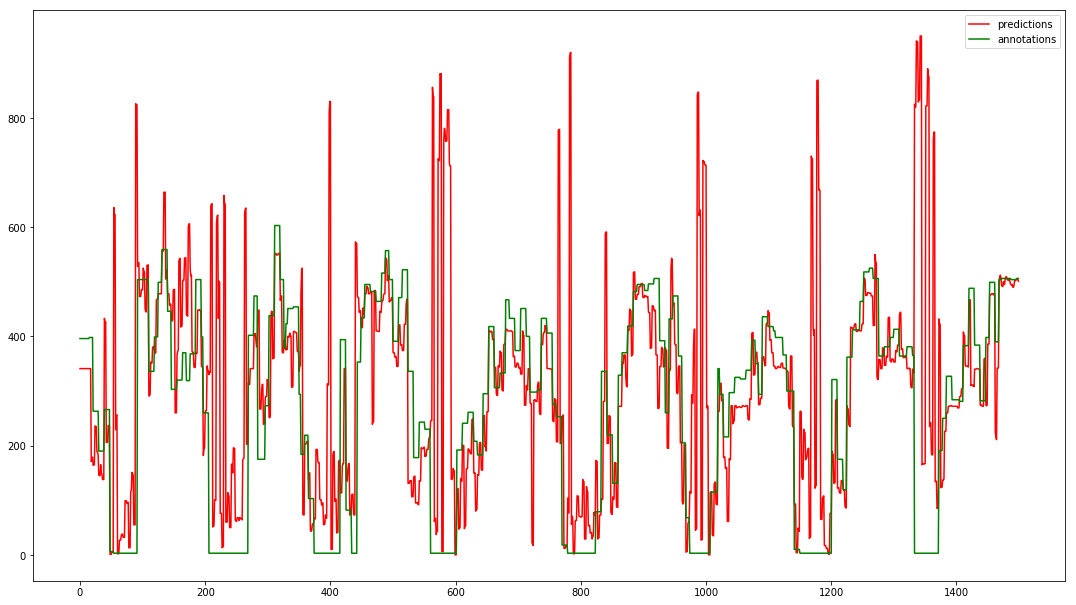

In [42]:
start = 9500
end   = 11000
#end   = start+len(preds_converted)
preds_converted = [int(p*(1024/NUM_BINS)) for p in predictions]
# labels = [ele[1] for ele in all_data_sequential]
x_ax = range(len(preds_converted[start:end]))
# print(np.shape(labels[:-46]))
print(np.shape(preds_converted))
fig = plt.figure()
fig.set_size_inches(18.5, 10.5)
plt.plot(x_ax, preds_converted[start:end], "-r", label="predictions")
plt.plot(x_ax, annotations[start:end], "-g", label="annotations")
plt.legend()
fig.savefig('tf_jp_clr_12500-14000_15bins.png', dpi=100)

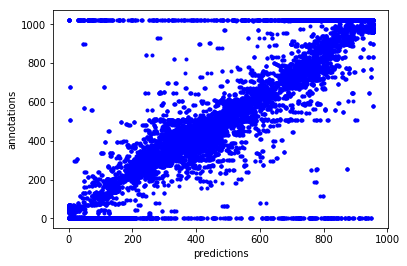

In [39]:
plt.plot(preds_converted, annotations[:-46], 'b.')
plt.xlabel("predictions")
plt.ylabel("annotations")
fig = plt.gcf()
fig.savefig('tf_jp_clr_15bins_scatter.png', dpi=100)

In [29]:
count_hig = 0
count_low = 0
count     = 0
for ele in preds_converted:
    if ele > 1022:
        count_hig += 1
    elif ele < 23:
        count_low += 1
    else:
        count += 1

print(f"hight: {count_hig}")
print(f"low  : {count_low}")
print(f"rest  : {count}")
print(preds_converted[0])

hight: 5837
low  : 50
rest  : 13863
791


In [ ]:
#print(all_img_paths[0].split('/')[-1].split('.')[0])
for a, img_pth in zip(angles, all_img_paths):
    im = img_pth.split('/')[-1].split('.')[0]
    with open("./to_make_movie.txt", 'a') as file:
        file.write("{}, {}\n".format(im, a[0:0]))

In [ ]:
from annotate_video_inplace import *
saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess,'./ep_19-step_50-loss_0.5418351888656616.ckpt')
    
    video_inference(sess, x, prediction, training, "/home/jp/Documents/FYP/ml/data/videoplayback.mp4", "/home/jp/Desktop/video_infer")

In [ ]:
os.path.exists("/home/jp/Documents/FYP/ml/data/videoplayback.mp4")